In [1]:
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

In [2]:
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
sns.set_style('ticks', {'font.sans-serif':['simhei','Droid Sans Fallback']})

In [3]:
df_competitive=pd.read_csv("D:/从c盘转移的桌面/github/Competitive analysis/competitor.csv")
del df_competitive['Unnamed: 0']

In [4]:
df_competitive_rfm=df_competitive[['id','rank','date_d']].groupby(['id','date_d'],as_index=False).agg({'rank':'min'})
#each products every day rank
df_competitive_rfm.columns=['id','date_d','rank_min']
df_competitive_rfm['date_d']=pd.to_datetime(df_competitive_rfm.date_d)
df_competitive_rfm['isTop10']=df_competitive_rfm['rank_min'].apply(lambda x:1 if x<=10 else 0)
df_competitive_rfm['Datediff']=(df_competitive_rfm['date_d'].max()-df_competitive_rfm['date_d']).dt.days
#the time length between the last time and today
df_competitive_rfm_90=df_competitive_rfm[df_competitive_rfm.Datediff<=90]

In [5]:
#RFM
r_ = df_competitive_rfm_90.groupby('id')['Datediff'].agg([('R-the_last_time_get_on_the_list','min')])
#the highest rank in last time
f_ = df_competitive_rfm_90.groupby('id')['rank_min'].agg([('F-number_get_on_the_list','count')])
# top10 numbers
m1_ = df_competitive_rfm_90.groupby('id')['isTop10'].agg([('M1-number_get_on_the_top10','sum')])

In [6]:
temp = df_competitive_rfm_90[df_competitive_rfm_90.Datediff<=2]
m2_ = temp.groupby('id')['isTop10'].agg([('M2-the_numbers_get_on_the_top10_last_three_days','sum')])
m2_.sort_values('M2-the_numbers_get_on_the_top10_last_three_days')
#想在近两天上榜的名单里看看谁历史上上榜次数还最多
rfm = r_.join(f_).join(m1_).join(m2_)
rfm = rfm.fillna(0)

<AxesSubplot:>

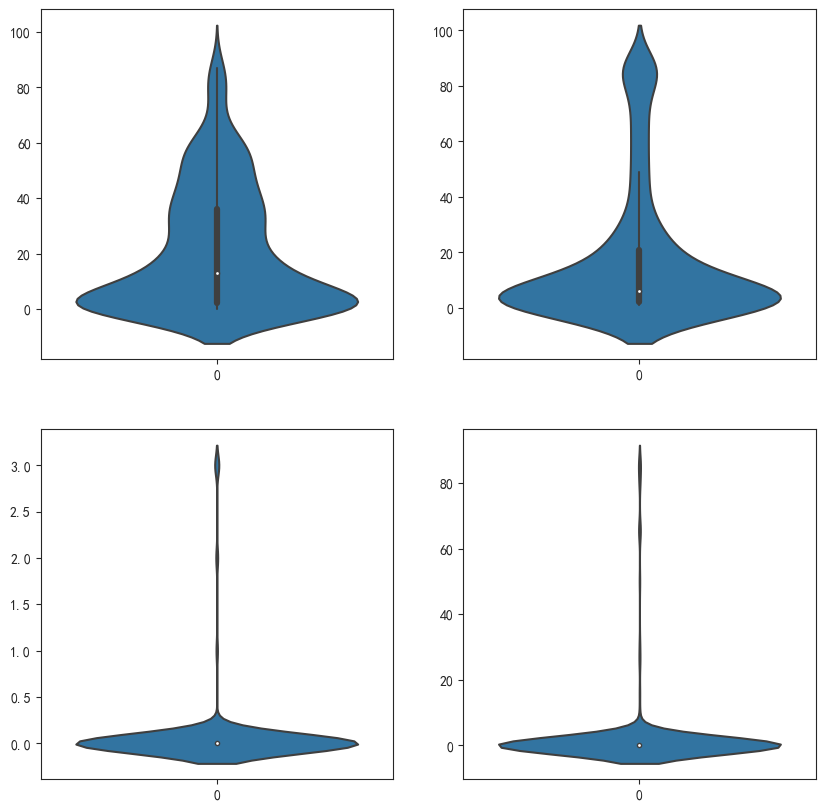

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.violinplot(rfm['R-the_last_time_get_on_the_list'])
plt.subplot(222)
sns.violinplot(rfm['F-number_get_on_the_list'])
plt.subplot(223)
sns.violinplot(rfm['M2-the_numbers_get_on_the_top10_last_three_days'])

plt.subplot(224)
sns.violinplot(rfm['M1-number_get_on_the_top10'])

In [8]:
# R
bins = [0,3,15,30,85,1000]
labels =  np.arange(5,0,-1)
rfm['R'] = pd.cut(rfm['R-the_last_time_get_on_the_list'], bins=bins, labels=labels, include_lowest=True).astype(float)

In [9]:
# F
bins = [0,20,40,60,80,1000]
labels =  np.arange(1,6)
rfm['F'] = pd.cut(rfm['F-number_get_on_the_list'], bins=bins, labels=labels, include_lowest=True).astype(float)

In [10]:

# M1
bins = [0,5,20,60,80,1000]
labels =  np.arange(1,6)
rfm['M1'] = pd.cut(rfm['M1-number_get_on_the_top10'], bins=bins, labels=labels, include_lowest=True).astype(float)

In [11]:
# M2
bins = [0,1,2,3,100]
labels =  np.arange(0,4)
rfm['M2'] = pd.cut(rfm['M2-the_numbers_get_on_the_top10_last_three_days'], bins=bins, labels=labels, include_lowest=True).astype(float)


In [12]:
rfm['R_value'] = rfm['R'].apply(lambda x: 'high' if x>rfm['R'].mean() else 'low')
rfm['F_value']=rfm['F'].apply(lambda x:'high' if x> rfm['F'].mean() else 'low')
rfm['M1_value']=rfm['M1'].apply(lambda x:'high' if x> rfm['M1'].mean() else 'low')
rfm['M2_value']=rfm['M2'].apply(lambda x:'high' if x> rfm['M2'].mean() else 'low')
rfm['rfm_value']=rfm['R_value']+rfm['F_value']+rfm['M1_value']+rfm['M2_value']

In [13]:
rfm2cat = {
'highhighhighhigh': 'Continuous monitoring of competitors',
'highhighlowhigh': 'Focus on researching old products',
'highlowhighhigh': 'Focus on researching new products',
'highhighhighlow': 'Focus on maintaining old products',
'lowlowlowhigh': 'General research on new products',
'highlowlowhigh': 'General research on new products',
'lowhighhighlow': 'Partial research on old products',
'highhighlowlow': 'General attention to old products',
'lowhighlowlow': 'General attention to old products',
}


<AxesSubplot:xlabel='Total_score', ylabel='Density'>

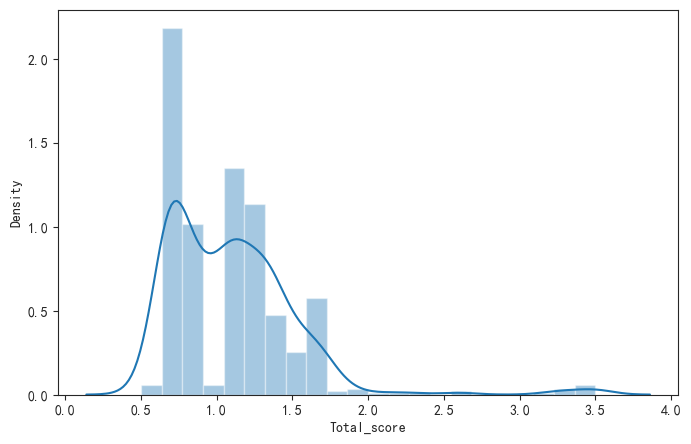

In [14]:
rfm['Label_of_product']=rfm['rfm_value'].map(rfm2cat)
rfm['Label_of_product']  = rfm['Label_of_product'] .fillna('do not care')
rfm['Total_score'] = rfm['R']*0.2 + rfm['F']*0.1 + rfm['M1']*0.2+rfm['M2']*0.5
rfm['update_day']='2020-03-08'
plt.figure(figsize=(8,5))
sns.distplot(rfm.Total_score)